In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
pip install surprise

In [0]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Python/Lab/Lab 5/ratings_Electronics.csv", header=None, names=["userID", "itemID","ratings","timestamp"])
data.sample(10)

,userID,itemID,ratings,timestamp
2968011,A7NYOTASQDRO2,B002ZV9VXE,1.0,1353974400
770264,A15QQY2BZXCVYC,B000BQ7GW8,3.0,1395273600
4300184,A3SS3AIE4U9EP5,B004NONCXQ,1.0,1395792000
6091018,A2LMYYOK23RP1L,B00871SR68,2.0,1403827200
2925476,A2UE7IZWQWC1JA,B002WPUC5Y,3.0,1364428800
3896773,AEU0GUTZT1E0C,B0045VXORG,5.0,1396742400
495637,A2CY5TQ166U1FC,B0002MPNLC,5.0,1365552000
1461516,A1GSUST2D6VMKA,B000VX6XL6,4.0,1378771200
7447703,A3F2AUIISSQ5PH,B00DR0PDNE,3.0,1386633600
1508410,A1L9OD3II2VEGI,B000X24ISU,5.0,1369612800


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userID       object
itemID       object
ratings      float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [54]:
data.shape

(7824482, 4)

In [55]:
data_new = data.sample(782448)
data_new.sample(5)

,userID,itemID,ratings,timestamp
4734373,A1B7GZK7NERS90,B0056KDRQI,5.0,1360195200
7822387,A3B6Z1GY0TMUSE,B00KI2BD1U,5.0,1405555200
2133412,A27WQZ71RHA2S4,B001M5U76O,3.0,1401840000
3202191,A38U3Q9TDS3SSC,B003BERYLA,4.0,1380499200
5566568,A3L2HUAQPFN5VR,B0072N4TNW,5.0,1339027200


In [56]:
data_new.shape

(782448, 4)

In [57]:
data.isnull().any()

userID       False
itemID       False
ratings      False
timestamp    False
dtype: bool

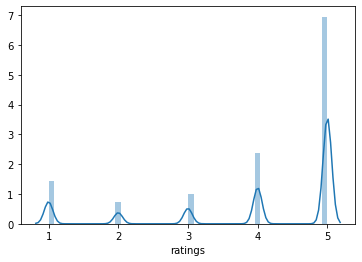

In [58]:
sns.distplot(data["ratings"], kde=True)

## Making the dataset denser

In [0]:
count_user = data["userID"].value_counts()

In [0]:
data_new = data[data["userID"].isin(count_user[count_user>=50].index)]

In [61]:
data_new.shape

(125871, 4)

## Popularity Recommendetion model

In [0]:
data_pop = data_new

In [63]:
data_pop.groupby('itemID')['ratings'].mean().head()

itemID
0594451647    5.000000
0594481813    3.000000
0970407998    2.500000
0972683275    4.750000
1400501466    3.333333
Name: ratings, dtype: float64

In [64]:
data_pop.groupby('itemID')['ratings'].mean().sort_values(ascending=False).head()

itemID
B00LKG1MC8    5.0
B002QUZM3M    5.0
B002QWNZHU    5.0
B002QXZPFE    5.0
B002R0DWNS    5.0
Name: ratings, dtype: float64

In [65]:
data_pop.groupby('itemID')['ratings'].count().sort_values(ascending=False).head()

itemID
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
Name: ratings, dtype: int64

In [0]:
ratings_mean_count = pd.DataFrame(data_pop.groupby('itemID')['ratings'].mean())

In [67]:
ratings_mean_count

,ratings
itemID,
0594451647,5.000000
0594481813,3.000000
0970407998,2.500000
0972683275,4.750000
1400501466,3.333333
...,...
B00LED02VY,4.000000
B00LGN7Y3G,5.000000
B00LGQ6HL8,5.000000


In [0]:
ratings_mean_count['rating_counts'] = pd.DataFrame(data_pop.groupby('itemID')['ratings'].count())

In [69]:
ratings_mean_count.head()

,ratings,rating_counts
itemID,,
0594451647,5.000000,1
0594481813,3.000000,1
0970407998,2.500000,2
0972683275,4.750000,4
1400501466,3.333333,6


## Collaborative Filtering model

In [0]:
from surprise import KNNWithMeans
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

In [0]:
reader = Reader(rating_scale=(1, 5))
data_colab = Dataset.load_from_df(data_new[['userID', 'itemID', 'ratings']], reader)

In [0]:
trainset, testset = train_test_split(data_colab, test_size=.30)

In [73]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
uid = str(196)
iid = str(302)

In [75]:
pred = algo.predict(uid, iid, verbose=True)

user: 196        item: 302        r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}


In [0]:
test_pred = algo.test(testset)

In [0]:
df = pd.DataFrame(test_pred, columns=['uid', 'iid', 'r_ui', 'est', 'details'])
best_predictions = df.sort_values(by='r_ui', ascending=False)

## Evaluate both the models

In [78]:
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0509


1.0509003129675238

## Get top 5 recommendations

In [79]:
ratings_mean_count.sort_values(by='rating_counts', ascending=False).head()

,ratings,rating_counts
itemID,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


In [89]:
best_predictions.head()

,uid,iid,r_ui,est,details
18881,AAEVGE52KL0DJ,B00B6ZCNGM,5.0,4.574468,"{'actual_k': 0, 'was_impossible': False}"
15832,A2RS66Y79Q8X0W,B001FSBZNC,5.0,4.260836,"{'was_impossible': True, 'reason': 'User and/o..."
15856,A2I357I10ZY7CI,B000NFIW98,5.0,4.327273,"{'actual_k': 0, 'was_impossible': False}"
29272,A8FKL1DHTHC12,B00741IGFY,5.0,4.434783,"{'actual_k': 0, 'was_impossible': False}"
15854,A17V9XL4CWTQ6G,B002I0K3Z2,5.0,4.260836,"{'was_impossible': True, 'reason': 'User and/o..."
